# `numpy` Neural Networks: Multi-Layer Perceptron

Now that we've done one layer successfully, let's try more! We begin with adding one hidden layer to our network, and then generalize to include any number of hidden layers. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

The "hard" dataset that we couldn't predict with logistic regression:

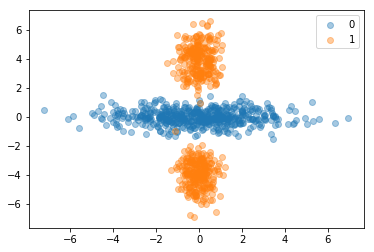

In [2]:
def min_max_scale(X):
    #http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
    return (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

n_samples = 1000
X0 = np.random.normal(loc=[0,0], scale=[2,0.5], size=(int(n_samples/2), 2))
X11 = np.random.normal(loc=[0,4], scale=[0.5,1], size=(int(n_samples/4), 2))
X12 = np.random.normal(loc=[0,-4], scale=[0.5,1], size=(int(n_samples/4), 2))
X1 = np.vstack([X11, X12])
X = np.vstack([X0, X1])

# X = min_max_scale(X)

y0 = np.zeros(shape=(int(n_samples/2), 1))
y1 = np.ones(shape=(int(n_samples/2), 1))
yhat = np.vstack([y0, y1])

plt.scatter(*X0.T, label='0', alpha=0.4); plt.scatter(*X1.T, label='1', alpha=0.4)
plt.legend();

In [3]:
X.shape

(1000, 2)

Sigmoid Activation and Cross-Entropy Loss

In [4]:
def sig(z):
    return 1 / (1 + np.exp(-z))

def dsig_dz(z):
    return sig(z) * (1 - sig(z))

def J(y, yhat):
    return -(yhat*np.log(y) + (1-yhat)*np.log(1-y))

def dJ_dy(y, yhat):
    return (1-yhat)/(1-y) - yhat/y

For our hidden layer we will use a new type of unit (neuron w/ activation function): The rectified linear function. 
$$\mathrm{ReLU}(x) = \begin{cases}
x & x\ge0\\
0 & x<0
\end{cases} $$

This activation is nice because it is fast to compute, and it doesn't saturate, by which we mean the derivative doesn't go to zero asymptotically, so terms that depend on the derivative don't die out:

$$\frac{\mathrm{d}\,\mathrm{ReLU}}{\mathrm{d}x} = \begin{cases}
1 & x\ge0\\
0 & x<0
\end{cases} $$

In [5]:
def relu(z):
    return np.where(z>0, z, 0)
    
def drelu_dz(z):
    return np.where(z>0, 1, 0)

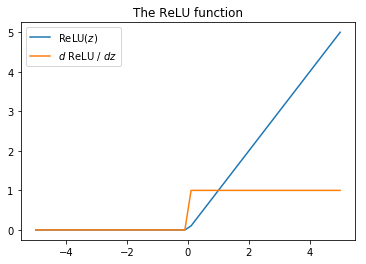

In [6]:
z = np.linspace(-5,5)
plt.plot(z, relu(z), label='ReLU$(z)$'); plt.plot(z, drelu_dz(z), label='$d$ ReLU / $dz$'); plt.legend();
plt.title('The ReLU function');

# 1 Hidden Layer

Let's consider the case of having a single hidden ReLU layer with 2 hidden units. 

In [7]:
n_input = 2
n_hidden = 10
n_output = 1

We now have two sets of weights, $w^1$ and $w^2$. We must now consider the biases as matrices connecting the units of consecutive layers. Define them to have the same number of rows as units in the previous layer, and the same number of columns as units in the next layer. So $w^1 \in \Re^{(2,2)}$ and $w^2 \in \Re^{(2,1)}$. We will also explicitly consider bias vectors $b^1$ and $b^2$ which have the size of the next layer (one bias per activation unit).

In the previous notebook, we dealt with bias by setting $x_0 = 0$ and then adding an additional weight, but I now find it more clear to just add the bias separately. In any case the effect is the same. The actions of the layers are then:

\begin{align*}
z^1 &= x^0 w^1 + b^{1\mathrm{T}} & x^1 &= \mathrm{ReLU}(z^1) \\
z^2 &= x^1 w^2 + b^{2\mathrm{T}} & y &= \sigma(z^1)
\end{align*}

Here we denote the sigmoid function as $\sigma$. The bias vectors are transposed since each $x$ is a row. 

Let's initialize some random nonzero weights to demonstrate as we go along:

In [8]:
w1 = np.random.normal(0,0.1, size=(n_input, n_hidden))
w2 = np.random.normal(0,0.1, size=(n_hidden, n_output))

b1 = np.random.normal(0,0.1, size=(n_hidden,1))
b2 = np.random.normal(0,0.1, size=(n_output,1))

alpha = 0.1

The forward pass is simply the calculation performed above:

In [9]:
def forward1(x0, w1, b1, w2, b2):
    x1 = relu(np.dot(x0, w1) + b1.T)  # output of hidden layer
    return sig(np.dot(x1, w2) + b2.T)  # output of output layer

We can check the prediction on the first sample:

In [10]:
y = forward1(X[0], w1, b1, w2, b2)
y

array([[ 0.50032214]])

For the backward pass, we follow the approach detailed in [this video](https://www.youtube.com/watch?v=gl3lfL-g5mA) and define a quantity that will become useful later on: $\delta^\ell$, the partial derivative of the cost function with respect to $z^\ell$:

$$ \delta^\ell \equiv \frac{\partial J}{\partial z^\ell} $$

Explicit calculation begins with the last delta:

\begin{align*}
\delta^2 &= \frac{\partial J}{\partial z^2}\\
&= \frac{\partial J}{\partial y}\frac{\partial y}{\partial z^2}\\
&= \frac{\partial J}{\partial y} \frac{\partial \sigma}{\partial z^2}\\
\end{align*}


Moving on to $\delta^1$, we repeatedly apply the chain rule to find

\begin{align*}
\delta^1 &= \frac{\partial J}{\partial z^1}\\
&= \frac{\partial J}{\partial z^2}\frac{\partial z^2}{\partial z^1}\\
&= \frac{\partial J}{\partial z^2}\frac{\partial z^2}{\partial x^1}\frac{\partial x^1}{\partial z^1}\\
&= w^2 \delta^{2T} \odot \mathrm{ReLU}^\prime(z^1)
\end{align*}
where $\odot$ is element-wise multiplication. Note that once we explicitly wrote out the matrix notation some of the terms changed position for dimensional reasons.

We see that $\delta^2$ appeared in the definition of $delta^1$. Furthermore, the update rules for both $w$ and $\beta$ can be written in terms of $\delta$:

\begin{align*}
\frac{\partial J}{\partial w^\ell} &= \frac{\partial J}{\partial z^\ell} \frac{\partial z^\ell}{\partial w^\ell}\\
&= (\delta^\ell x^{\ell-1})^T
\end{align*}

\begin{align*}
\frac{\partial J}{\partial b^\ell} &= \frac{\partial J}{\partial z^\ell} \frac{\partial z^\ell}{\partial b^\ell}\\
&= \delta^{\ell T}
\end{align*}

Armed with these convenient definitions we can implement our backward pass to update our weights, and our training function, which looks much the same as in the previous notebook:

In [11]:
def backward1(x0, w1, b1, w2, b2, y, yhat, alpha):
    # quantities
    z1 = np.dot(x0, w1) + b1.T
    x1 = relu(z1)
    z2 = np.dot(x1, w2) + b2.T
    #y = sig(z2)

    delta2 = dJ_dy(y, yhat) * dsig_dz(z2)
    delta1 = np.dot(w2, delta2) * drelu_dz(z1).T

    w2 -= alpha * np.multiply(delta2, x1).T
    w1 -= alpha * np.multiply(delta1, x0).T

    b2 -= alpha * delta2
    b1 -= alpha * delta1
    
    return w1, b1, w2, b2

In [12]:
y = forward1(X[0], w1, b1, w2, b2)
w1, b1, w2, b2 = backward1(X[0], w1, b1, w2, b2, y, yhat[0], alpha)
print(y)
print(J(y, yhat[0]))

[[ 0.50032214]]
[[ 0.69379166]]


In [13]:
def train1(X, yhat, n_hidden, alpha, n_epoch):
    n_samples = X.shape[0]
    n_input = X.shape[1]
    n_output = 1
    
    # keep track of performance during training
    costs = np.zeros(shape=(n_epoch,1))

    # random nonzero initialization
    w1 = np.random.normal(0, 0.1, size=(n_input, n_hidden))
    w2 = np.random.normal(0, 0.1, size=(n_hidden, n_output))
    
    b1 = np.random.normal(0, 0.1, size=(n_hidden, 1))
    b2 = np.random.normal(0, 0.1, size=(n_output, 1))

    for epoch in range(n_epoch):
        for i in range(n_samples):
            x0 = X[i,:]; yh = yhat[i]
            y = forward1(x0, w1, b1, w2, b2)  # prediction for one sample
            w1, b1, w2, b2 = backward1(x0, w1, b1, w2, b2, y, yh, alpha)  # take step
        
        # ### Some niceness to see our progress
        # Calculate total cost after epoch
        predictions = forward1(X, w1, b1, w2, b2)  # predictions for entire set
        costs[epoch] = np.mean(J(predictions, yhat))  # mean cost per sample
        # report progress
        if ((epoch % 10) == 0) or (epoch == (n_epoch - 1)):
            #print(predictions.round())
            accuracy = np.mean(predictions.round() == yhat)  # current accuracy on entire set
            print('Training accuracy after epoch {}: {:.4%}'.format(epoch, accuracy))
            
    return w1, b1, w2, b2, costs

Let's give it a try!

In [14]:
n_epoch = 200
n_hidden = 2
alpha = 0.001
w1, b1, w2, b2, costs = train1(X, yhat, n_hidden, alpha, n_epoch)

Training accuracy after epoch 0: 50.6000%
Training accuracy after epoch 10: 70.4000%
Training accuracy after epoch 20: 73.2000%
Training accuracy after epoch 30: 73.4000%
Training accuracy after epoch 40: 74.0000%
Training accuracy after epoch 50: 83.3000%
Training accuracy after epoch 60: 97.9000%
Training accuracy after epoch 70: 99.4000%
Training accuracy after epoch 80: 99.5000%
Training accuracy after epoch 90: 99.7000%
Training accuracy after epoch 100: 99.7000%
Training accuracy after epoch 110: 99.7000%
Training accuracy after epoch 120: 99.7000%
Training accuracy after epoch 130: 99.7000%
Training accuracy after epoch 140: 99.7000%
Training accuracy after epoch 150: 99.7000%
Training accuracy after epoch 160: 99.7000%
Training accuracy after epoch 170: 99.7000%
Training accuracy after epoch 180: 99.7000%
Training accuracy after epoch 190: 99.7000%
Training accuracy after epoch 199: 99.7000%


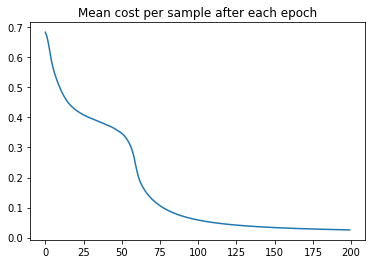

In [15]:
plt.plot(costs); plt.title('Mean cost per sample after each epoch');

Managed to escape a local minimum there!

In [16]:
x1 = np.linspace(-8,8)
x2 = np.linspace(-10,10)
fun_map = np.empty((x1.size, x2.size))
for n,i in enumerate(x1):
    for m,j in enumerate(x2):
        fun_map[m,n] = forward1([i,j], w1, b1, w2, b2)

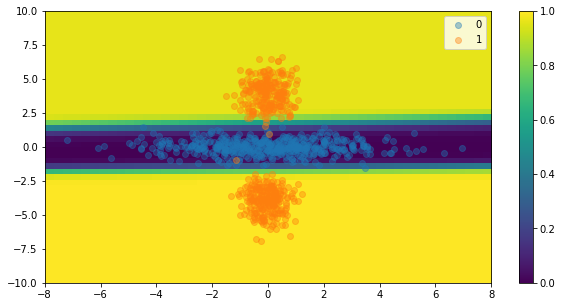

In [17]:
X0 = X[(yhat==0).reshape(-1)]
X1 = X[(yhat==1).reshape(-1)]

plt.figure(figsize=(10,5))
plt.imshow(fun_map, extent=[x1.min(), x1.max(), x2.min(), x2.max()], 
           vmin=0, vmax=1, aspect='auto')
plt.colorbar()
plt.scatter(*X0.T, label='0', alpha=0.4); plt.scatter(*X1.T, label='1', alpha=0.4)
plt.legend();

Looks pretty good! 

# $n$ Hidden Layers

Our functions are starting to take a lot of parameters, which is often a sign that you should be generalizing. Since all our definitions are recursive anyway, we can actually handle any number of layers with ease. 

Instead of specifying `n_hidden`, we will move to specifying the number of units per layer (including the input and output layers), using a tuple which we'll call `shape`. 

We will store quantities that are matrix-valued but inconsistent in dimension across different layers in a dictionary.

In [18]:
def init_model(shape):
    w = {}
    b = {}
    for layer, n_units in enumerate(shape):
        if layer > 0:  # no weights for the input layer
            w[layer] = np.random.normal(0,0.1, size=(shape[layer-1], shape[layer]))
            b[layer] = np.random.normal(0,0.1, size=(shape[layer],1))
    return w,b

In [19]:
def forwardn(x0, w, b):
    n_layers = len(w)
    x_prev = x0
    for l in range(1, n_layers):
        x_l = relu(np.dot(x_prev, w[l]) + b[l].T)  # output of a hidden layer
        x_prev = x_l
    return sig(np.dot(x_prev, w[n_layers]) + b[n_layers].T)  # output of output layer

Let's test these out with a much of layers!

In [20]:
t = (2,3,6,8,1,)

In [21]:
w,b = init_model(t)

In [22]:
print(w)

{1: array([[ 0.24462671, -0.01293406, -0.06346043],
       [-0.0155312 , -0.12582292,  0.08274153]]), 2: array([[-0.16921756,  0.15193863, -0.14220898,  0.08573722, -0.02513851,
        -0.18343867],
       [-0.03510496, -0.04763423, -0.02272288, -0.10277767,  0.09947756,
         0.0726747 ],
       [-0.19163266, -0.00809894,  0.04715465, -0.08134942, -0.07818889,
         0.28164081]]), 3: array([[-0.00580368,  0.01526758,  0.064587  ,  0.18565612, -0.08216244,
         0.10650539, -0.1045736 , -0.0388064 ],
       [-0.04779124, -0.0220689 ,  0.05260915, -0.17459846, -0.01838656,
         0.0121771 ,  0.04163936,  0.07687954],
       [ 0.0576938 , -0.17245954, -0.08704065,  0.08672164, -0.19032444,
        -0.1427627 ,  0.0954758 , -0.21979943],
       [-0.00202167,  0.20653072,  0.13151335, -0.09111205, -0.14274482,
        -0.09777095, -0.02175314,  0.04621345],
       [-0.02032231, -0.02050593, -0.15204207, -0.06694883,  0.06453773,
         0.14929054, -0.20211916, -0.04052046],


In [23]:
y = forwardn(X[:10], w, b)
y

array([[ 0.48648299],
       [ 0.48648159],
       [ 0.48657108],
       [ 0.48649433],
       [ 0.48646318],
       [ 0.48647216],
       [ 0.48647595],
       [ 0.48655467],
       [ 0.4865545 ],
       [ 0.486528  ]])

In [24]:
def backwardn(x0, w, b, y, yhat, alpha):
    n_layers = len(w)
    z = {}
    x = {0:x0}
    
    # x and z values for calculating derivatives
    for l in range(1, n_layers+1):
        z[l] = np.dot(x[l-1], w[l]) + b[l].T
        x[l] = relu(z[l])
        
    delta = {}
    
    # deltas and updates
    for l in range(n_layers, 0, -1):  # start with last layer and move backward
        if l == n_layers:  # base case
            delta[l] = dJ_dy(y, yhat)*dsig_dz(z[n_layers])
        else:  # recursive case
            delta[l] = np.dot(w[l+1], delta[l+1]) * drelu_dz(z[l]).T

        # update weights and biases
        w[l] -= alpha * np.multiply(delta[l], x[l-1]).T
        b[l] -= alpha * delta[l]
    
    return w, b

Does this work for a simple case? If we update a bunch of times using one sample and set $\hat y=0$, we should see the prediction move towards 0:

In [25]:
for i in range(1000):
    w,b = backwardn(X[0], w, b, y[0], 0, 0.1)
    y[0] = forwardn(X[0], w, b)
    if i%100 == 0:
        print(y[0],'-->',yhat[0])

[ 0.47373359] --> [ 0.]
[ 0.05592278] --> [ 0.]
[ 0.01609937] --> [ 0.]
[ 0.0076168] --> [ 0.]
[ 0.00455696] --> [ 0.]
[ 0.00309926] --> [ 0.]
[ 0.00228148] --> [ 0.]
[ 0.00177129] --> [ 0.]
[ 0.0014285] --> [ 0.]
[ 0.00118527] --> [ 0.]


Awesome! Confident, we also implement the training function to do this with all the samples:

In [26]:
def trainn(X, yhat, shape, alpha, n_epoch):
    n_samples = X.shape[0]
    n_input = X.shape[1]
    
    # keep track of performance during training
    costs = np.zeros(shape=(n_epoch,1))

    # random nonzero initialization
    w,b = init_model(shape)

    for epoch in range(n_epoch):
        for i in range(n_samples):
            x0 = X[i,:]; yh = yhat[i]
            y = forwardn(x0, w, b)  # prediction for one sample
            w, b = backwardn(x0, w, b, y, yh, alpha)  # take step
        
        # ### Some niceness to see our progress
        # Calculate total cost after epoch
        predictions = forwardn(X, w, b)  # predictions for entire set
        costs[epoch] = np.mean(J(predictions, yhat))  # mean cost per sample
        # report progress
        if ((epoch % 10) == 0) or (epoch == (n_epoch - 1)):
            accuracy = np.mean(predictions.round() == yhat)  # current accuracy on entire set
            print('Training accuracy after epoch {}: {:.4%}'.format(epoch, accuracy))
            
    return w, b, costs

In [27]:
n_epoch = 200
shape = (2,5,3,1)
alpha = 0.001
w, b, costs = trainn(X, yhat, shape, alpha, n_epoch)

Training accuracy after epoch 0: 50.0000%
Training accuracy after epoch 10: 50.0000%
Training accuracy after epoch 20: 96.0000%
Training accuracy after epoch 30: 99.6000%
Training accuracy after epoch 40: 99.7000%
Training accuracy after epoch 50: 99.7000%
Training accuracy after epoch 60: 99.7000%
Training accuracy after epoch 70: 99.7000%
Training accuracy after epoch 80: 99.8000%
Training accuracy after epoch 90: 99.8000%
Training accuracy after epoch 100: 99.8000%
Training accuracy after epoch 110: 99.8000%
Training accuracy after epoch 120: 99.8000%
Training accuracy after epoch 130: 99.8000%
Training accuracy after epoch 140: 99.8000%
Training accuracy after epoch 150: 99.8000%
Training accuracy after epoch 160: 99.8000%
Training accuracy after epoch 170: 99.8000%
Training accuracy after epoch 180: 99.8000%
Training accuracy after epoch 190: 99.8000%
Training accuracy after epoch 199: 99.8000%


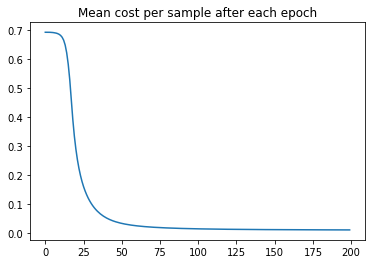

In [28]:
plt.plot(costs); plt.title('Mean cost per sample after each epoch');

In [29]:
x1 = np.linspace(-8,8)
x2 = np.linspace(-10,10)
fun_map = np.empty((x1.size, x2.size))
for n,i in enumerate(x1):
    for m,j in enumerate(x2):
        fun_map[m,n] = forwardn([i,j], w, b)

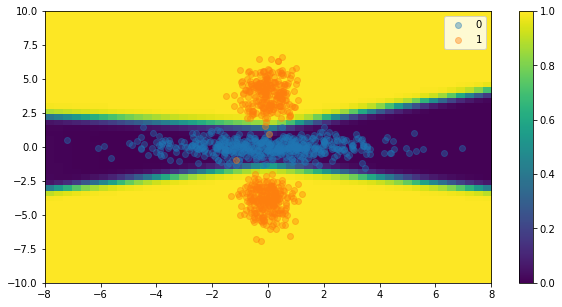

In [30]:
X0 = X[(yhat==0).reshape(-1)]
X1 = X[(yhat==1).reshape(-1)]

plt.figure(figsize=(10,5))
plt.imshow(fun_map, extent=[x1.min(), x1.max(), x2.min(), x2.max()], 
           vmin=0, vmax=1, aspect='auto')
plt.colorbar()
plt.scatter(*X0.T, label='0', alpha=0.4); plt.scatter(*X1.T, label='1', alpha=0.4)
plt.legend();

Even more flexibility than before!

Of course unlimited flexibility has its own pitfalls, so in the next notebook we'll look into some ways of getting that under control.